# The Schlesinger-Kozinec algorithm for optimal separating hyperplanes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

For background on the Schlesinger-Kozinec algorithm, we refer to the accompanying PDF file.
In what follows, we implement the SK algorithm and compare it with the perceptron algorithm.

### Preprocessing the input data

`x_train`: NumPy-array containing the $m$ data points in $\mathbb{R}^{n}$ to be separated according to labels; shape is `(m,n)`.

`y_train`: NumPy-array containing the corresponding labels, taking values in $\{-1, 1\}$; shape is `(m,)`.

Given `x_train` and `y_train`, the following function constructs the collection of ''augmented'' datapoints $\{\xi_{1},\dots,\xi_{m}\}$, where $\xi_{i}=y_{i}(x_{i},1)\in\mathbb{R}^{n+1}$.

In [2]:
def augment(x_train, y_train):
    xi_train = np.append(x_train, np.ones((x_train.shape[0],1)), axis=1) # Append a 1 to each data point
    xi_train = xi_train * y_train.reshape(-1,1) # Multiply each data point by its label
    return xi_train

**Example:** The following randomly generates collections `x_train` and `y_train` of data points and labels, respectively.

In [3]:
m, n = 5, 3 # Set number and dimension of data points, respectively.

x_train = np.random.randint(-10, 10, size=(m,n)) # Generate data points; chosen to be integers for simplicity.
y_train = np.random.choice([-1,1], size=m) # Generate corresponding labels.
print(x_train)
print(y_train)

[[ 4  3 -1]
 [ 8 -3 -7]
 [-3  2 -2]
 [-7 -2  2]
 [ 9 -4 -5]]
[-1 -1  1 -1  1]


The collection $\{\xi_{1},\dots,\xi_{m}\}\subset\mathbb{R}^{n+1}$ is obtained as follows.

In [4]:
xi_train = augment(x_train, y_train)
print(xi_train)

[[-4. -3.  1. -1.]
 [-8.  3.  7. -1.]
 [-3.  2. -2.  1.]
 [ 7.  2. -2. -1.]
 [ 9. -4. -5.  1.]]


### Implementing the algorithm

We can now implement the SK algorithm as follows. Recall that the algorithm involves a hyperparameter $\varepsilon$ which determines how close the output of the algorithm is to the theoretically optimal separating hyperplane. Unless specified otherwise, the following implementation sets $\varepsilon=0.005$.
The numbering of the steps of the algorithm is as in the accompanying PDF.

In [5]:
def schlesinger_kozinec(x_train, y_train, epsilon=0.005):
    xi_train = augment(x_train, y_train)
    omega = xi_train[0] # Step 1: Initialization of omega
    while np.linalg.norm(omega) - np.min((1/np.linalg.norm(omega))*np.array([np.dot(omega, xi) for xi in xi_train])) > epsilon: # Step2a: Check whether the stopping condition is satisfied
        xi_k = xi_train[np.argmin(np.dot(xi_train, omega))] # Step 2b: Set xi_k to be that data point that has minimal dot product with omega
        t_star = np.min([1,np.dot(omega, omega-xi_k) / np.dot(omega-xi_k, omega-xi_k)])
        omega = (1-t_star)*omega + t_star*xi_k # Step 3: Set the new value of omega using the value vor t_star found in the preceding line.
    return omega

### Comparison of the SK algorithm with the perceptron

We are now ready to apply the SK algorithm. We will do so by randomly generating two blobs of points that (almost always) result in two linearly separable sets in $\mathbb{R}^{2}$.
For comparison, we will run both the SK algorithm and the perceptron algorithm on these data points in order to visualize how the perceptron typically ends up quite far from the optimal separating hyperplane.

Before getting started, we load some auxiliary code that is used for loading and visualization of the data points.
Note that the function `load_data` has an optional argument `seed`.
If specified to any number, this ''disables'' the randomness in the creation of the data points, which may be useful if one wishes to reproduce certain examples more than once.
Additionally, we load a function that implements the perceptron.

In [6]:
def load_data(center_1, center_2, m=100, seed=None):
    if seed:
        np.random.seed(seed=seed)
    x_train = np.r_[np.random.randn(m,2)*0.5 + center_1, np.random.randn(m,2)*0.5 + center_2]
    y_train = np.r_[-np.ones(m), np.ones(m)]
    return x_train, y_train

def plot_data(x,y):
    plt.figure(figsize=(14,8))
    plt.scatter(x[:,0], x[:,1], c=y)
    plt.axis('scaled')
    plt.xlim([np.min(x_train[:,0])-0.5, np.max(x_train[:,0])+0.5])
    plt.ylim([np.min(x_train[:,1])-0.5, np.max(x_train[:,1])+0.5])


def plot_hyperplane(h, c=None, label=None):
    t = np.linspace(np.min(x_train[:,0])-0.5,np.max(x_train[:,0])+0.5,100)
    plt.plot(t, (-1/h[1])*(h[0]*t+h[2]), c=c, label=label)
    plt.legend()
    plt.axis('scaled')
    plt.xlim([np.min(x_train[:,0])-0.5, np.max(x_train[:,0])+0.5])
    plt.ylim([np.min(x_train[:,1])-0.5, np.max(x_train[:,1])+0.5])

def perceptron(x_train,y_train):
    num_data = len(x_train)
    w, b = np.array([0,0]), 0
    while True:
        updated = False
        for i in range(num_data):
            if y_train[i]*(np.dot(w,x_train[i]) + b) <= 0:
                w = w + y_train[i]*x_train[i]
                b = b + y_train[i]
                updated = True
        if not updated:
            break
    return np.r_[w, b]

The following loads an artificial two-dimensional labeled dataset, which is constructed as a collection of points around two points whose coordinates are specified by `center_1` and `center_2`.

**Note:** Depending on the choice of `center_1` and `center_2`, the dataset may result in two collections that are not linearly separable (which can normally be seen simply by looking at the resulting plot).
In this case, both the SK and the perceptron algorithm will not terminate, and so one should rerun the cell before proceeding in order to obtain two collections that are linearly separable.

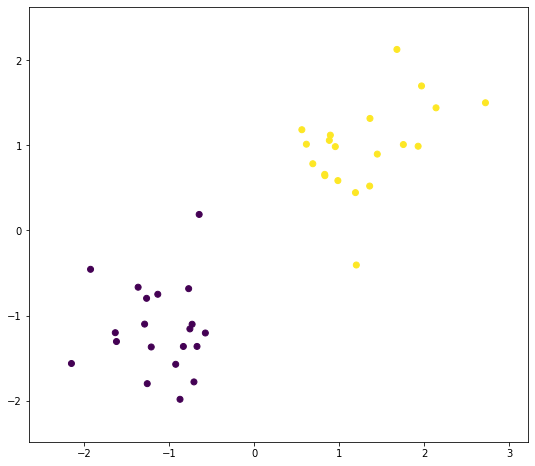

In [30]:
center_1, center_2 = [-1,-1], [1,1] # Set the coordinates of the centers of the two blobs
x_train, y_train = load_data(center_1, center_2, 20) # Create the data points and their labels
plot_data(x_train,y_train)

In [31]:
omega_sk = schlesinger_kozinec(x_train, y_train) # Apply SK algorithm to data set
omega_perceptron = perceptron(x_train, y_train) # Apply perceptron algorithm to data set
print(omega_sk)
print(omega_perceptron)

[ 0.66759981  0.23920154 -0.12812821]
[ 2.15062324  1.56450606 -1.        ]


Both `schlesinger_kozinec` as well as `perceptron` return a vector of the form $(w,b)\in\mathbb{R}^{2}\times\mathbb{R}$, where $w$ and $b$ are the parameters determining the separating hyperplane with respect to the coordinates of `x_train` (as opposed to the augmented version `xi_train`).
This allows us to plot the hyperplanes found by the two algorithms.

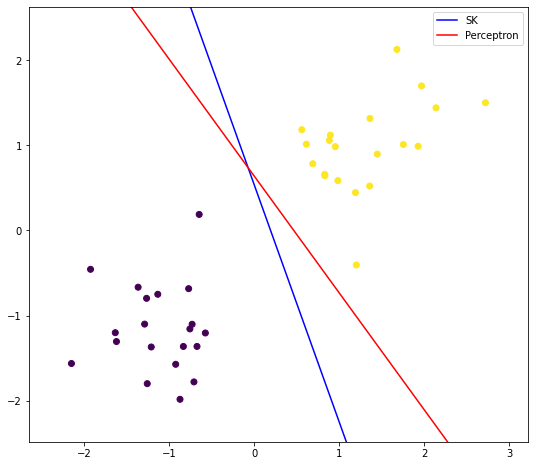

In [32]:
plot_data(x_train,y_train)
plot_hyperplane(omega_sk, c='b', label='SK')
plot_hyperplane(omega_perceptron, c='r', label='Perceptron')